# Personal Finance Machine Learning

The goal of this notebook is to create machine learning models to tackle 2 problems:

1) Supervised learning: Create a classification model that can predict the topic of a given submission title.

2) Unsupervised learning: Create a topic modeling system that can generate topics based on the words in the submission title.

In [3]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

# Import the data
from pf import *

In [5]:
data_words = df.lemmatized_title

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.phrases.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.phrases.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\joshu\Anaconda3\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['way', 'make', 'extra', 'side', 'money']


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [17]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

print(data_words_bigrams[:1])

[['way', 'make', 'extra', 'side', 'money']]


In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [19]:
id2word[0]

'extra'

In [20]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('extra', 1), ('make', 1), ('money', 1), ('side', 1), ('way', 1)]]

In [21]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [22]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.118*"buy" + 0.079*"look" + 0.075*"house" + 0.060*"school" + 0.056*"rent" '
  '+ 0.039*"worth" + 0.032*"another" + 0.022*"thing" + 0.021*"property" + '
  '0.020*"close"'),
 (1,
  '0.149*"take" + 0.072*"budget" + 0.034*"still" + 0.030*"never" + '
  '0.029*"family" + 0.027*"gift" + 0.019*"step" + 0.017*"real_estate" + '
  '0.017*"owe" + 0.016*"ago"'),
 (2,
  '0.074*"bank" + 0.067*"company" + 0.067*"plan" + 0.051*"find" + '
  '0.038*"interest" + 0.023*"state" + 0.023*"leave" + 0.022*"anyone" + '
  '0.021*"benefit" + 0.021*"if"'),
 (3,
  '0.237*"debt" + 0.044*"collection" + 0.033*"recently" + 0.031*"vehicle" + '
  '0.024*"hsa" + 0.021*"smart" + 0.020*"call" + 0.019*"cc" + 0.017*"vanguard" '
  '+ 0.017*"employee"'),
 (4,
  '0.257*"k" + 0.108*"insurance" + 0.045*"life" + 0.043*"sell" + 0.041*"just" '
  '+ 0.035*"stock" + 0.035*"lose" + 0.031*"health" + 0.027*"situation" + '
  '0.016*"buying"'),
 (5,
  '0.175*"need" + 0.155*"car" + 0.141*"help" + 0.108*"good" + 0.025*"name" + '
  '0.

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.74986519539897

Coherence Score:  0.5003085479749301


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
14     9.609136        1       1  0.282008 -0.337677
12     9.143374        1       2  0.321291  0.304907
9      6.204037        1       3  0.035846 -0.014650
5      5.631248        1       4 -0.000688  0.002552
19     5.551012        1       5  0.010481 -0.000302
8      5.347335        1       6 -0.032291  0.002187
15     4.972658        1       7 -0.012051  0.002351
13     4.968477        1       8 -0.026157  0.000188
2      4.957076        1       9 -0.035438  0.002373
17     4.880880        1      10 -0.021544  0.002468
6      4.417106        1      11 -0.049879  0.003157
4      4.348820        1      12 -0.026820  0.000268
0      4.316479        1      13 -0.039801  0.003160
10     4.035624        1      14 -0.052099  0.002940
11     3.891917        1      15 -0.055228  0.006257
7      3.844504        1      16 -0.055039  0.004074
18     3.821026        1      17 -0.053393  0.003189
16     3.781311        1      18 -0.062150  0.003072
3      3.478492        1      19 -0.055165  0.005447
1      2.799487        1      20 -0.071881  0.004039, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
9     Default  3096.000000            i  3096.000000  30.0000  30.0000
35    Default  1016.000000       credit  1016.000000  29.0000  29.0000
88    Default  1001.000000           be  1001.000000  28.0000  28.0000
11    Default   808.000000            k   808.000000  27.0000  27.0000
46    Default   775.000000          get   775.000000  26.0000  26.0000
53    Default   955.000000          pay   955.000000  25.0000  25.0000
156   Default   746.000000         what   746.000000  24.0000  24.0000
67    Default   904.000000         loan   904.000000  23.0000  23.0000
106   Default   644.000000       advice   644.000000  22.0000  22.0000
47    Default   710.000000         need   710.000000  21.0000  21.0000
45    Default   596.000000         debt   596.000000  20.0000  20.0000
77    Default   623.000000          how   623.000000  19.0000  19.0000
66    Default   630.000000          car   630.000000  18.0000  18.0000
7     Default   574.000000         help   574.000000  17.0000  17.0000
73    Default   551.000000         card   551.000000  16.0000  16.0000
2     Default   507.000000        money   507.000000  15.0000  15.0000
17    Default   517.000000         year   517.000000  14.0000  14.0000
217   Default   519.000000          not   519.000000  13.0000  13.0000
10    Default   557.000000          job   557.000000  12.0000  12.0000
181   Default   476.000000           do   476.000000  11.0000  11.0000
6     Default   386.000000           go   386.000000  10.0000  10.0000
166   Default   438.000000         good   438.000000   9.0000   9.0000
19    Default   378.000000      account   378.000000   8.0000   8.0000
87    Default   514.000000      student   514.000000   7.0000   7.0000
191   Default   367.000000          buy   367.000000   6.0000   6.0000
1     Default   348.000000         make   348.000000   5.0000   5.0000
123   Default   369.000000          tax   369.000000   4.0000   4.0000
163   Default   301.000000         take   301.000000   3.0000   3.0000
154   Default   340.000000    insurance   340.000000   2.0000   2.0000
128   Default   441.000000       should   441.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
57    Topic20   145.559795       budget   146.420638   3.5698  -2.6301
752   Topic20    68.043161        still    68.904004   3.5632  -3.3906
639   Topic20    60.027596        never    60.888439   3.5615  -3.5159
884   Topic20    58.107278       family    58.968121   3.5610  -3.5484
266   Topic20    54.224824         gift    55.085667   3.5600  -3.6176
445   Topic20    38.234659         step    39.095502   3.5535  -3.9670
632   Topic20    34.66

In [26]:
import os
os.environ.update({'MALLET_HOME': r'c:/mallet-2.0.8/'})

mallet_path = 'C:/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [27]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('pay', 0.32190179267342167),
   ('debt', 0.26773187840997664),
   ('transfer', 0.03117692907248636),
   ('balance', 0.026110678098207326),
   ('cc', 0.024162120031176928),
   ('collector', 0.012470771628994544),
   ('feel', 0.011691348402182385),
   ('apr', 0.010911925175370226),
   ('consolidate', 0.009353078721745909),
   ('percentage', 0.00779423226812159)]),
 (14,
  [('car', 0.27412814274128144),
   ('payment', 0.10786699107866991),
   ('worth', 0.048256285482562854),
   ('cost', 0.025952960259529603),
   ('repair', 0.01824817518248175),
   ('monthly', 0.015815085158150853),
   ('screw', 0.013787510137875101),
   ('experience', 0.012976480129764802),
   ('miss', 0.012976480129764802),
   ('require', 0.012570965125709651)]),
 (10,
  [('tax', 0.18767967145790554),
   ('question', 0.1347022587268994),
   ('owe', 0.030800821355236138),
   ('state', 0.02997946611909651),
   ('return', 0.026694045174537988),
   ('file', 0.026694045174537988),
   ('gift', 0.02135523613963039),
 

NameError: name 'data_lemmatized' is not defined

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

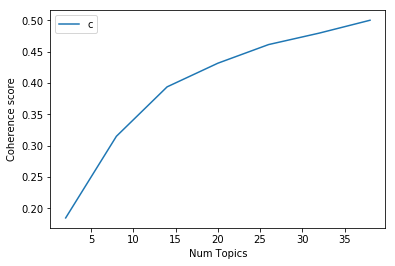

In [31]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1846
Num Topics = 8  has Coherence Value of 0.315
Num Topics = 14  has Coherence Value of 0.394
Num Topics = 20  has Coherence Value of 0.4317
Num Topics = 26  has Coherence Value of 0.4615
Num Topics = 32  has Coherence Value of 0.4798
Num Topics = 38  has Coherence Value of 0.5004


In [33]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.139*"ira" + 0.093*"roth" + 0.087*"question" + 0.031*"contribution" + '
  '0.023*"employer" + 0.022*"limit" + 0.022*"contribute" + 0.021*"hsa" + '
  '0.020*"vanguard" + 0.020*"put"'),
 (1,
  '0.275*"car" + 0.161*"buy" + 0.029*"lease" + 0.023*"vehicle" + 0.023*"break" '
  '+ 0.019*"repair" + 0.014*"lot" + 0.013*"trade" + 0.012*"person" + '
  '0.012*"financing"'),
 (2,
  '0.273*"debt" + 0.041*"collection" + 0.034*"report" + 0.030*"owe" + '
  '0.025*"day" + 0.025*"send" + 0.024*"cc" + 0.021*"call" + 0.021*"free" + '
  '0.019*"yo"'),
 (3,
  '0.196*"money" + 0.148*"make" + 0.023*"extra" + 0.023*"paycheck" + '
  '0.022*"gift" + 0.021*"dollar" + 0.020*"inheritance" + 0.016*"refund" + '
  '0.015*"sense" + 0.015*"father"'),
 (4,
  '0.233*"year" + 0.059*"back" + 0.057*"school" + 0.039*"change" + '
  '0.039*"wife" + 0.034*"expense" + 0.030*"lose" + 0.026*"friend" + '
  '0.021*"career" + 0.021*"grad"'),
 (5,
  '0.131*"start" + 0.096*"work" + 0.043*"salary" + 0.042*"raise" + '
  '0.030*"in

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.title):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.title)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.0895,"money, make, extra, paycheck, gift, dollar, in...",Ways to make extra side money?
1,1,3.0,0.0948,"money, make, extra, paycheck, gift, dollar, in...","(Year UPDATE) Legally blind, going homeless, h..."
2,2,5.0,0.0686,"start, work, salary, raise, increase, uk, rece...","19, being kicked out"
3,3,19.0,0.1038,"account, saving, bank, check, open, close, tra...",Online Savings Account?
4,4,10.0,0.0833,"good, option, investment, budget, small, app, ...",Tools for Managing Incomes and Expenses


In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2100,"ira, roth, question, contribution, employer, l...",I know that Roth contributions can be accessed...
1,1.0,0.1898,"car, buy, lease, vehicle, break, repair, lot, ...","I (22) bought a car for 3800 Euro, Transmissio..."
2,2.0,0.1608,"debt, collection, report, owe, day, send, cc, ...",My credit report is showing an outstanding deb...
3,3.0,0.1443,"money, make, extra, paycheck, gift, dollar, in...",I made a cash deposit in a bank ATM machine. T...
4,4.0,0.1214,"year, back, school, change, wife, expense, los...",Finally done with residency after 3.5 years (d...
5,5.0,0.1843,"start, work, salary, raise, increase, uk, rece...",Found a document on a work PC that outlines my...
6,6.0,0.2230,"tax, income, question, live, state, file, work...","Tax question, hypothetical for now: If I live ..."
7,7.0,0.1528,"advice, retirement, plan, good, idea, bad, fut...",I (29 - $120k/yr) am getting married (31 - $11...
8,8.0,0.1882,"job, offer, receive, leave, employer, week, cu...",I have just recently left a job after I receiv...
9,9.0,0.1750,"fund, cash, charge, give, amount, fee, return,...",Any red flags depositing large cash amount equ...


In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"money, make, extra, paycheck, gift, dollar, in...",694.0,0.0682
1,3.0,"money, make, extra, paycheck, gift, dollar, in...",707.0,0.0694
2,5.0,"start, work, salary, raise, increase, uk, rece...",629.0,0.0618
3,19.0,"account, saving, bank, check, open, close, tra...",469.0,0.0461
4,10.0,"good, option, investment, budget, small, app, ...",501.0,0.0492
5,15.0,"advice, financial, house, sell, parent, busine...",500.0,0.0491
6,17.0,"move, payment, pay, rent, house, afford, apart...",547.0,0.0537
7,0.0,"ira, roth, question, contribution, employer, l...",463.0,0.0455
8,2.0,"debt, collection, report, owe, day, send, cc, ...",500.0,0.0491
9,2.0,"debt, collection, report, owe, day, send, cc, ...",426.0,0.0418
